# Reference Architecture for LLM applications using Redis & Google Cloud Platform

<a href="https://colab.research.google.com/github/RedisVentures/redis-google-llms/blob/main/BigQuery_Palm_Redis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook serves as a getting-started guide for working with LLMs on Google Cloud Platform with Redis Enterprise.

## Intro
Google's Vertex AI has expanded its capabilities by introducing [Generative AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview). This advanced technology comes with a specialized [in-console studio experience](https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/quickstart), a [dedicated API](https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/api-quickstart) and [Python SDK](https://cloud.google.com/vertex-ai/docs/python-sdk/use-vertex-ai-python-sdk) designed for deploying and managing instances of Google's powerful PaLM language models (more sample code). With a distinct focus on text generation, summarization, chat completion, and embedding creation, PaLM models are reshaping the boundaries of natural language processing and machine learning.

Redis Enterprise offers robust vector database features, with an efficient API for vector index creation, management, distance metric selection, similarity search, and hybrid filtering. When coupled with its versatile data structures - including lists, hashes, JSON, and sets - Redis Enterprise shines as the optimal solution for crafting high-quality Large Language Model (LLM)-based applications. It embodies a streamlined architecture and exceptional performance, making it an instrumental tool for production environments.



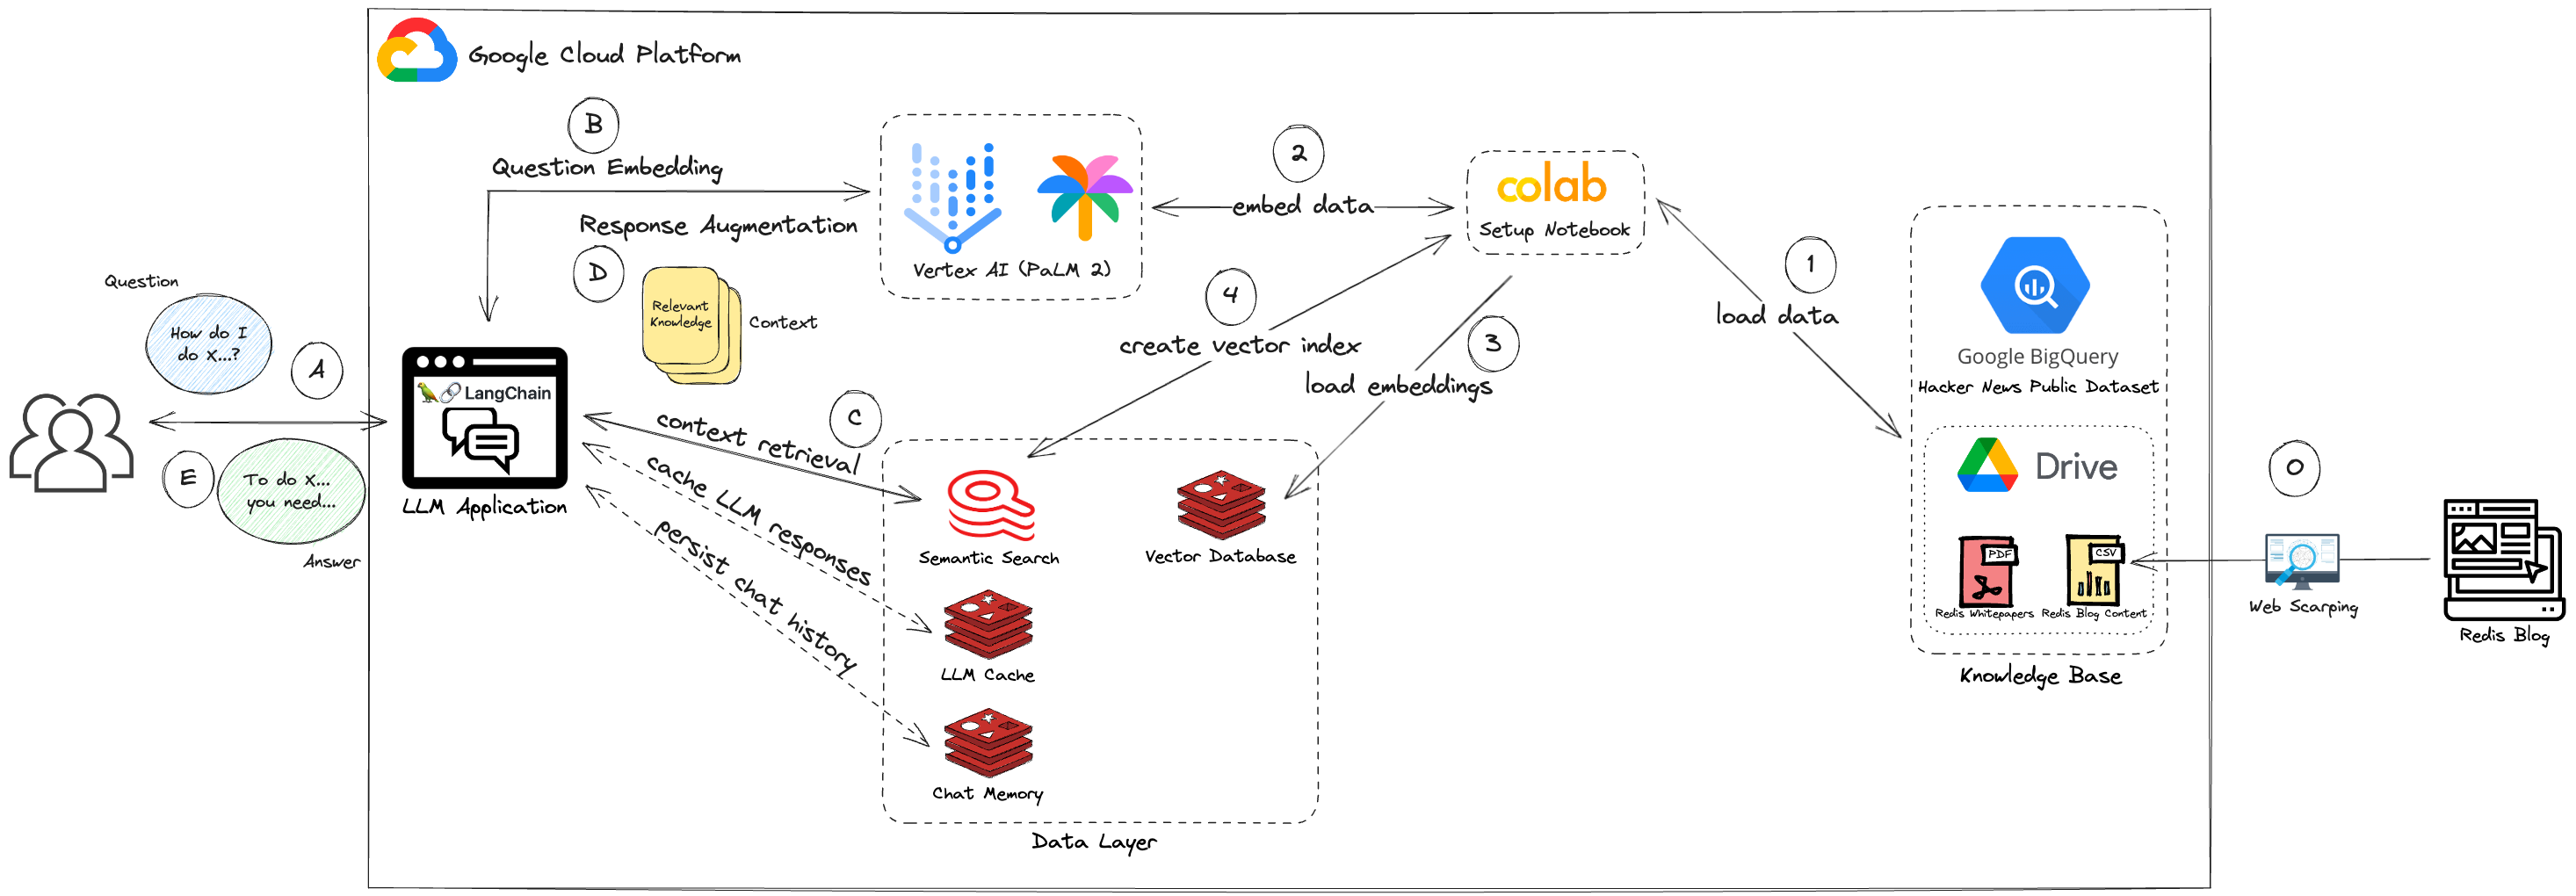

Below we will work through several design patterns with Vertex AI LLMs and Redis Enterprise that will ensure optimal production performance.


___
## Contents
- Setup
    1. Prerequisites
      - Install required libraries
      - Import Libraries
      - Mount Google Drive
      - Authenticate to Google Cloud
      - Initialize Vertex AI Components
      - Connect to Redis Cluster
    2. Vector Similarity Search (VSS): Basics
      - Define embedding helper function
      - Data embedding
      - Vector storage
      - Vector indexing
      - Define a helper function to perform the KNN similarity search
      - Querying vectors
- LLM Application: Domain-Specific ChatBOT
    1. Documents Loading
      - Loading Redis Whitepapers (PDF)
      - Loading Redis Blog (URLs)
      - Loading Hacker News Dataset (BigQuery)
    2. Splitting
    3. Vector Storage & Indexing
    4. Retrieval    
      - Simple Similarity Search     
      - Retrieval Augmented Generation (RAG)
      - LLM Caching
        - Standard Caching
        - Semantic Caching
      - QA History
- User Interface
- Cleanup
___

# Setup

## 1. Prerequisites

Before we begin, we must install some required libraries, authenticate with Google, create a Redis database, and initialize other required components.


### Install required libraries

In [ ]:
! pip install langchain openai pypdf sentence_transformers tenacity redis redisvl gradio "google-cloud-aiplatform==1.25.0" --upgrade --user

^^^ If prompted press the Restart button to restart the kernel.^^^

### Import libraries

In [ ]:
from glob import glob
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import VertexAI
from langchain.vectorstores.redis import Redis as RedisVectorStore
from redisvl.llmcache.semantic import SemanticCache
from langchain.embeddings import VertexAIEmbeddings
from google.colab import auth
from getpass import getpass
from google.colab import drive
from google.cloud import bigquery
from vertexai.preview.language_models import TextEmbeddingModel
from vertexai.preview.language_models import TextGenerationModel
from tenacity import retry, stop_after_attempt, wait_random_exponential
from typing import Generator, List, Any
from redis.commands.search.query import Query
from redis.commands.search.field import (
    NumericField,
    TagField,
    TextField,
    VectorField,
)
from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)
import redis
import json
import vertexai
import logging
import hashlib
import random
import gradio as gr
import os
import sys
import pandas as pd
import numpy as np

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

### Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Authenticate to Google Cloud

In [ ]:
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# input your GCP project ID and region for Vertex AI
PROJECT_ID = getpass("PROJECT_ID:") #'central-beach-194106'
REGION = input("REGION:") #'us-central1'

PROJECT_ID:··········
REGION:us-central1


### Initialize Vertex AI Components


In [ ]:
vertexai.init(project=PROJECT_ID, location=REGION)

### Connect to Redis server
Replace the connection params below with your own if you are connecting to an external Redis instance.

In [ ]:
# Redis connection params
redis_url = "redis://redis-12000.cluster.dev-vss.demo.redislabs.com:12000"

# Create Redis client
redis_client = redis.from_url(redis_url)

# Test connection
redis_client.ping()

True

In [ ]:
# Clear Redis database (optional)
redis_client.flushdb()

True

## 2. Vector Similarity Search (VSS): Basics

### Define embedding helper function
We define a helper function, `embed_text`, to create embeddings from a list of texts while making it resilient to [Vertex AI API quotas](https://cloud.google.com/vertex-ai/docs/quotas) via [exponential backoff](https://en.wikipedia.org/wiki/Exponential_backoff).

We also define a method `convert_embedding` to convert an array of floats to a byte string for efficient storage in Redis.

The `textembedding-gecko` model accepts a maximum of 3,072 input tokens (i.e. words) and outputs 768-dimensional vector embeddings.

In [ ]:
# Embedding model definition from VertexAI PaLM API
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

# The embedding function
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(3))
def embed_text(text=[]):
    embeddings = embedding_model.get_embeddings(text)
    return [each.values for each in embeddings]

# Convert embeddings to bytes for Redis storage
def convert_embedding(emb: List[float]):
  return np.array(emb).astype(np.float32).tobytes()

### Data embeddings

> Embeddings are a dense vector representation of a piece of content such that, if two pieces of content are semantically similar, their respective embeddings are located near each other in the embedding vector space. This representation can be used to solve common NLP tasks, such as:
> - **Semantic search**: Search text ranked by semantic similarity.
> - **Recommendation**: Return items with text attributes similar to the given text.
> - **Classification**: Return the class of items whose text attributes are similar to the given text.
> - **Clustering**: Cluster items whose text attributes are similar to the given text.
> - **Outlier Detection**: Return items where text attributes are least related to the given text.



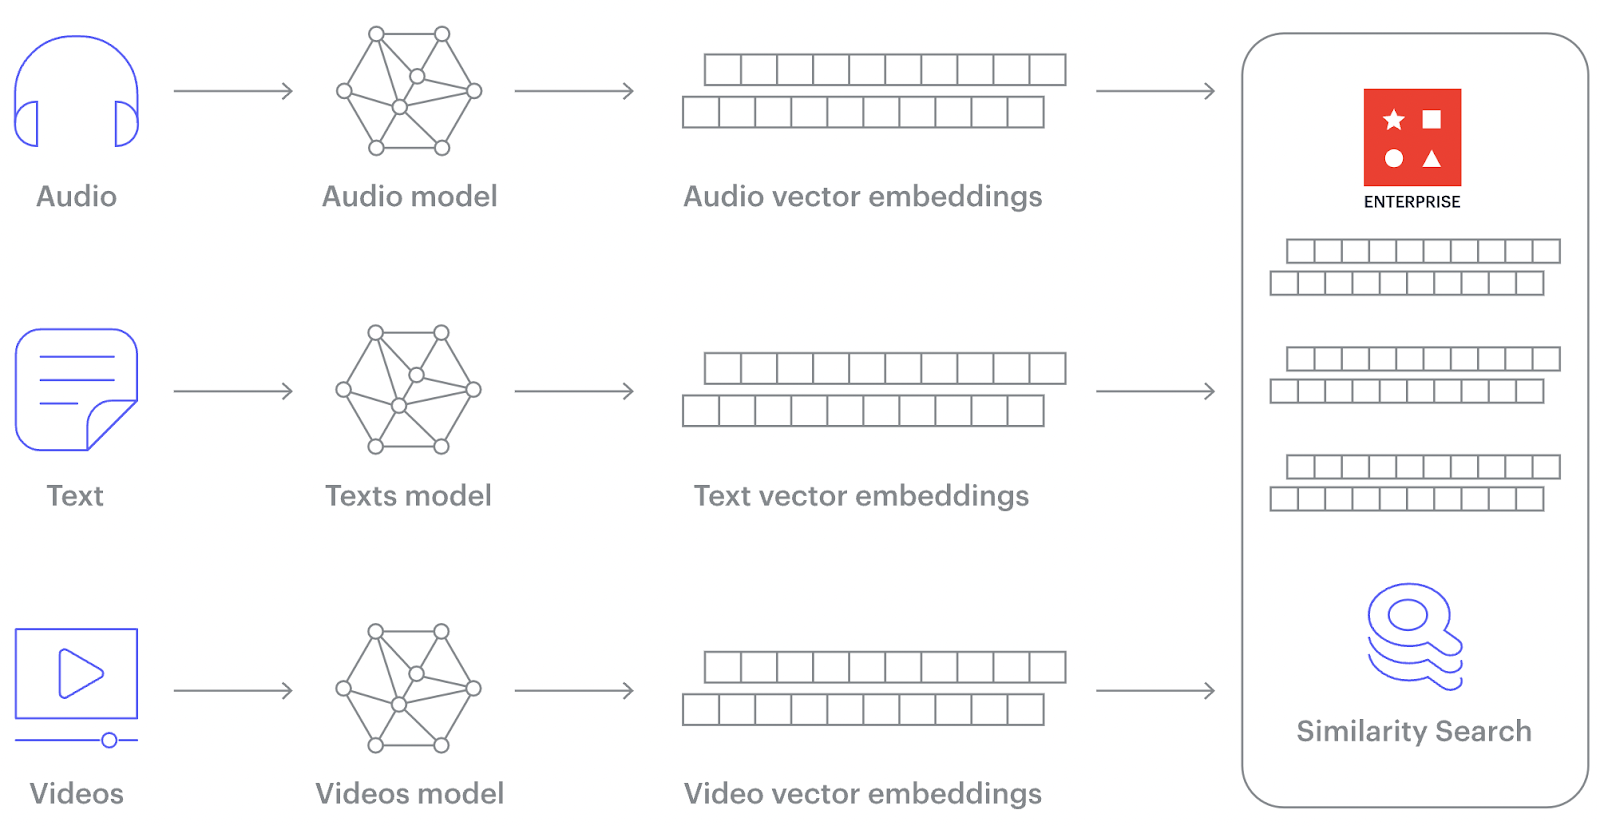

In [ ]:
sentence1 = "That is a very happy person"
sentence2 = "That is a happy girl"
sentence3 = "I love dogs"

In [ ]:
embedding1, embedding2, embedding3 = embed_text([sentence1, sentence2, sentence3])



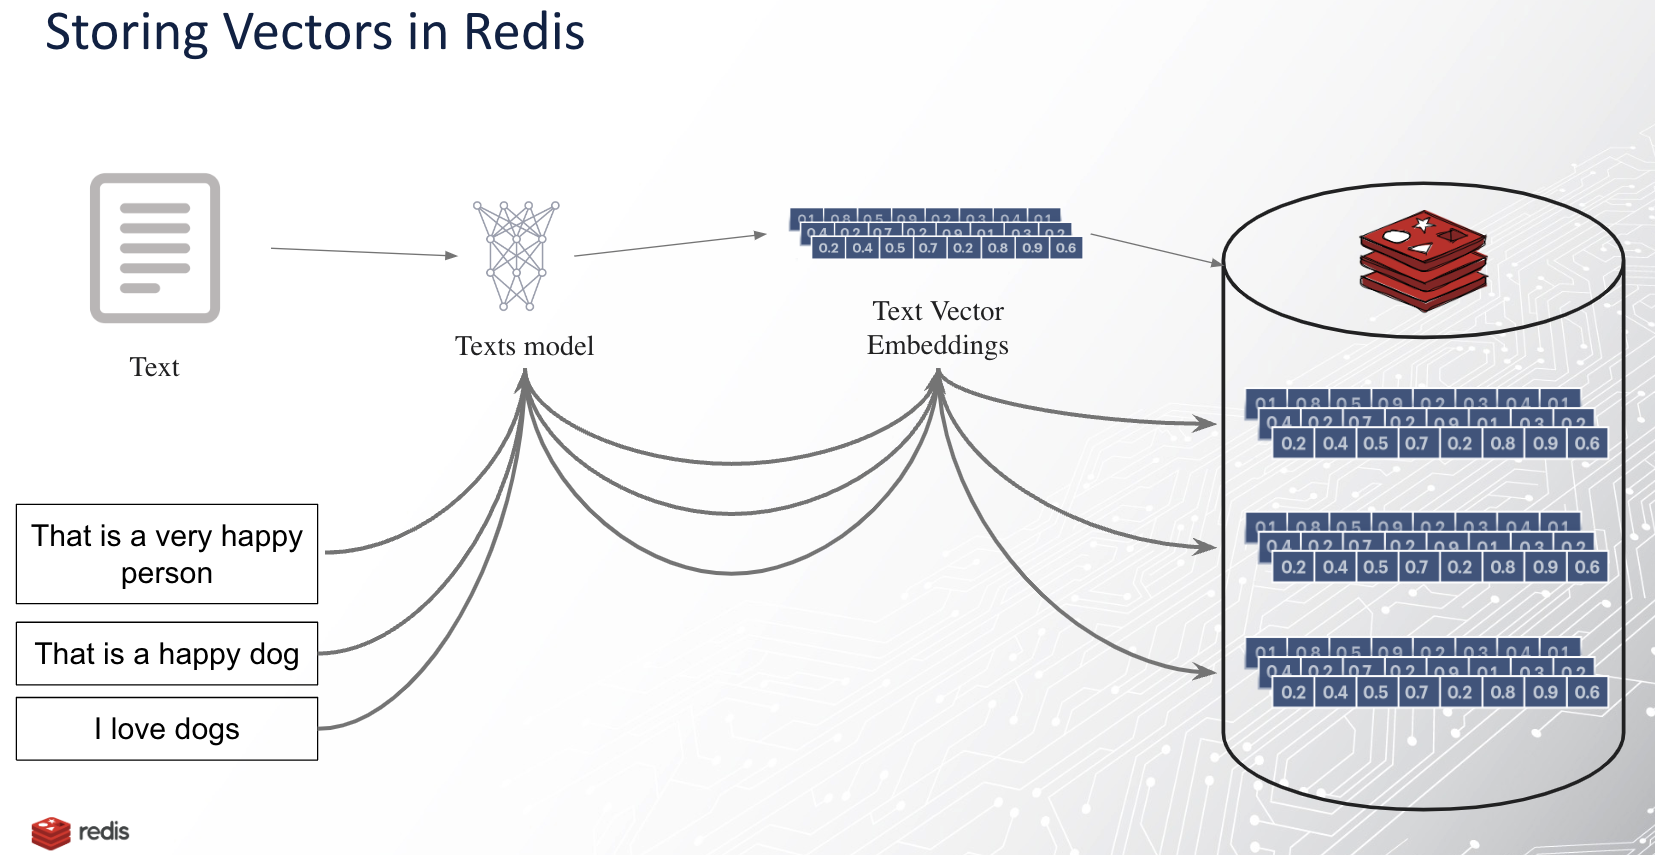

### Vector storage

Now that we created text embeddings let's write them to Redis:

In [ ]:
redis_client.hset('sentence:1', mapping={"text": sentence1, "embedding": convert_embedding(embedding1)})
redis_client.hset('sentence:2', mapping={"text": sentence2, "embedding": convert_embedding(embedding2)})
redis_client.hset('sentence:3', mapping={"text": sentence3, "embedding": convert_embedding(embedding3)})

2

### Vector indexing

After creating embeddings that represent the sentences and storing them in Redis, we will create a secondary index that enables efficient search over the embeddings. To learn more about the vector similarity features in Redis, [check out these docs](https://redis.io/docs/interact/search-and-query/search/vectors/) and [these Redis AI resources](https://github.com/RedisVentures/redis-ai-resources).

**Why do we need to enable search???**
Using Redis for vector similarity search allows us to retrieve chunks of text data that are **similar** or **relevant** to an input question or query. This will be extremely helpful for our sample generative ai / LLM application.

In [ ]:
INDEX_NAME = "sentences:idx"
PREFIX = "sentence:"
VECTOR_FIELD_NAME = "embedding"
VECTOR_DIMENSIONS = 768

# Store vectors in redis and create index
def create_redis_index(
    redis_client: redis.Redis,
    vector_field_name: str = VECTOR_FIELD_NAME,
    index_name: str = INDEX_NAME,
    prefix: list = [PREFIX],
    dim: int = VECTOR_DIMENSIONS
  ):

    # Construct index
    try:
        redis_client.ft(index_name).info()
        print("Existing index found. Dropping and recreating the index", flush=True)
        redis_client.ft(index_name).dropindex(delete_documents=False)
    except:
        print("Creating new index", flush=True)

    # Create new index
    redis_client.ft(index_name).create_index(
        (
            VectorField(
                vector_field_name, "FLAT",
                {
                    "TYPE": "FLOAT32",
                    "DIM": dim,
                    "DISTANCE_METRIC": "COSINE",
                }
            )
        ),
        definition=IndexDefinition(prefix=prefix, index_type=IndexType.HASH)
    )

In [ ]:
# Create index
create_redis_index(redis_client)

Creating new index


In [ ]:
# Inspect index attributes
redis_client.ft(INDEX_NAME).info()

{'index_name': 'sentences:idx',
 'index_definition': [b'key_type',
  b'HASH',
  b'prefixes',
  [b'sentence:'],
  b'default_score',
  b'1'],
 'attributes': [[b'identifier',
   b'embedding',
   b'attribute',
   b'embedding',
   b'type',
   b'VECTOR']],
 'index_options': [],
 'gc_stats': [b'bytes_collected', 0],
 'cursor_stats': [b'global_idle',
  0,
  b'global_total',
  0,
  b'index_capacity',
  128,
  b'index_total',
  0],
 'dialect_stats': [b'dialect_1', 0, b'dialect_2', 0, b'dialect_3', 0],
 'num_docs': 3,
 'max_doc_id': 3,
 'num_terms': 0,
 'num_records': 3,
 'inverted_sz_mb': '0',
 'total_inverted_index_blocks': 0,
 'vector_index_sz_mb': '3.0083847045898438',
 'offset_vectors_sz_mb': '0',
 'doc_table_size_mb': '0.000217437744140625',
 'sortable_values_size_mb': '0',
 'key_table_size_mb': '0.000110626220703125',
 'records_per_doc_avg': '1',
 'bytes_per_record_avg': '0',
 'offsets_per_term_avg': '0',
 'offset_bits_per_record_avg': '-nan',
 'indexing': 0,
 'percent_indexed': '1',
 'has

### Define a helper function to perform the KNN similarity search

We define a helper function, `similarity_search`, to create an embedding from the query sentence and compare it to other vectors having the same prefix according to the index created previously.

In [ ]:
# Helper method to perform KNN similarity search in Redis
def similarity_search(query: str, k: int, return_fields: tuple, index_name: str = INDEX_NAME) -> list:
    # create redis query object
    redis_query = (
        Query(f"*=>[KNN {k} @{VECTOR_FIELD_NAME} $embedding AS distance]")
            .sort_by("distance")
            .return_fields(*return_fields)
            .paging(0, k)
            .dialect(2)
    )
    # create embedding from query text
    query_vector = embed_text([query])[0]

    # execute the search
    results = redis_client.ft(index_name).search(
        redis_query, query_params={"embedding": convert_embedding(query_vector)}
    )
    return pd.DataFrame([t.__dict__ for t in results.docs ]).drop(columns=["payload"])

### Querying vectors
Let's create a query sentence and calculate its distance (similarity) with the sentences created previously.

In [ ]:
# 1. Create query vector
query_sentence = "That is a happy boy"

In [ ]:
# 2. Perform vector similarity search with given query
results = similarity_search(query_sentence, k=3, return_fields=("distance", "title", "text"))

In [ ]:
results['score'] = 1 - results['distance'].astype('float64')

In [ ]:
# 3. Review and return the results
display(results.sort_values("score", ascending=False).drop(columns=["distance"]))

id                         text     score
0  sentence:2         That is a happy girl  0.827555
1  sentence:1  That is a very happy person  0.779859
2  sentence:3                  I love dogs  0.514998



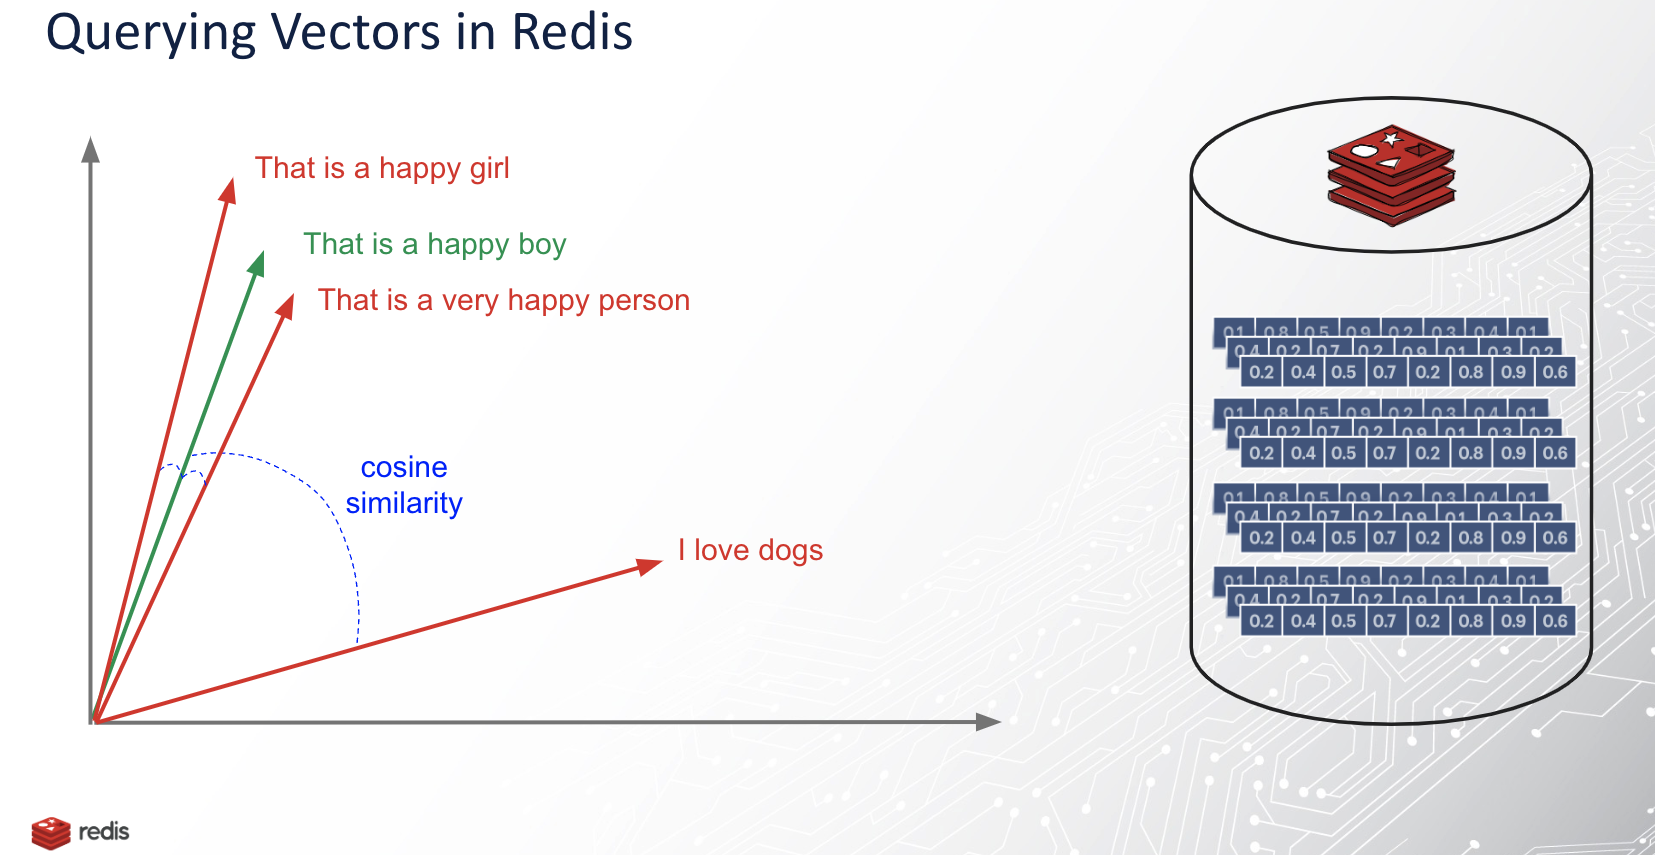

# LLM Application: Domain-Specific ChatBot

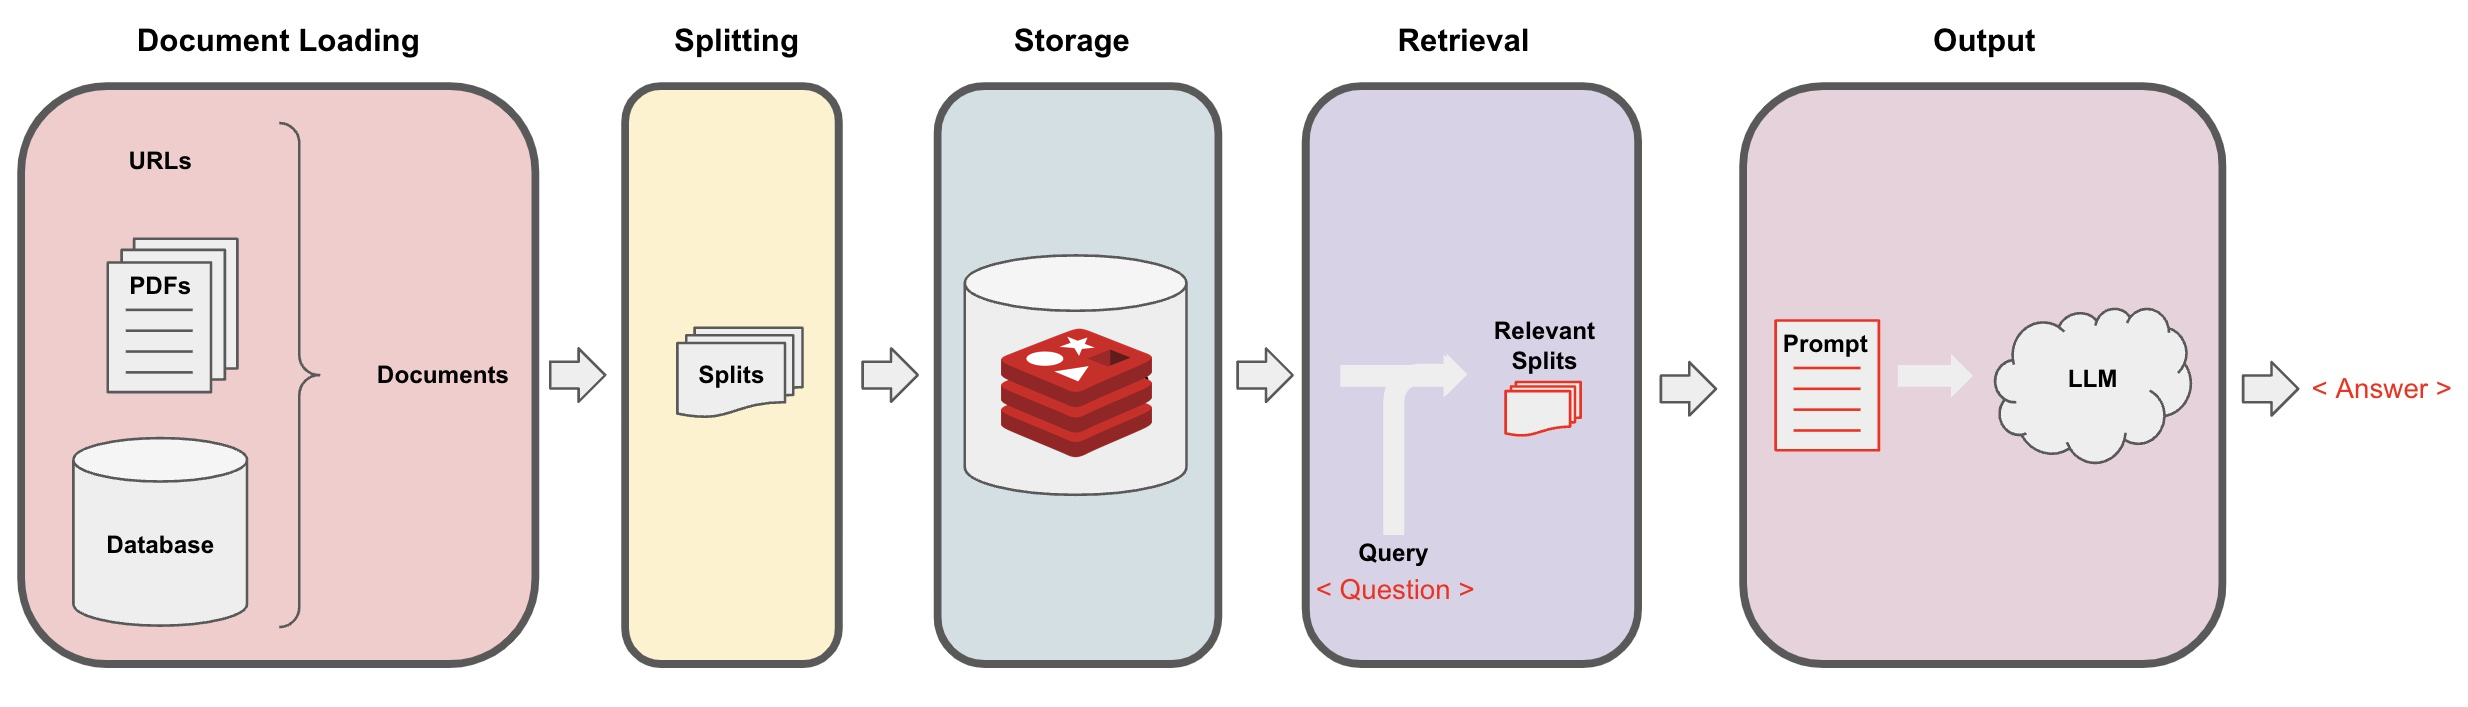

## 1. Documents Loading

### Loading Redis Whitepapers (PDF)
Let's load Redis Whitepapers (PDF document)

In [ ]:
pages = []

In [ ]:
dir = os.path.join("drive/MyDrive/ColabDrive/docs/pdf", "*.pdf")
loaders = [PyPDFLoader(file) for file in glob(dir)]

for loader in loaders:
    pages.extend(loader.load())

Each PDF page is a `Document`.

A `Document` contains text (`page_content`) and `metadata`.

In [ ]:
len(pages)

48

In [ ]:
print(pages[3].page_content)

4Gaming Use Cases Powered By Redis Enterprise 
Player Interactions
1 . Leaderboards and Ranking
Massively scalable multi-player games have challenging requirements of distributed computations and instantaneous 
visibility into who’s leading, by how much and how many are in the lead. Leaderboards are commonly used in gaming 
platforms where gamification can lead to better user experience. Sorted sets in Redis are a perfect fit for implementing a 
leaderboard, which has made Redis a popular choice for many gaming applications.
Figure 1. Keep track of users’ progress through ranking, scoring, and leaderboards
2 . Personalization
Gaming applications can use Redis Enterprise to collect and process high volumes of in-game data and segment gameplay 
variations and identify quickly top performing configurations. High velocity user acquisition and persistent user engagement 
both require gaming applications to respond with appropriate content in milliseconds. The blazing fast throughput and low

In [ ]:
print(pages[3].metadata)

{'source': 'drive/MyDrive/ColabDrive/docs/pdf/Redis Enterprise for Gaming Use Cases 2021.pdf', 'page': 3}


### Loading Redis Blog (URLs)

Let's load the Redis Blog posts

1. Extract the Redis blog posts into a CSV file.

In [ ]:
!python drive/MyDrive/ColabDrive/extract_redis_blog.py

Retrieving blogs after 2023-07-01T00:00:00+00:00
Processing post URL : 
https://redis.com/blog/cloud-migration-strategy-misconceptions/
Processing post URL : https://redis.com/blog/redisgraph-eol/
Processing post URL : 
https://redis.com/blog/i-have-500-million-keys-but-whats-in-my-redis-db/
Processing post URL : 
https://redis.com/blog/how-to-use-redis-at-least-x1000-more-efficiently/
Processing post URL : 
https://redis.com/blog/turbo-boost-wordpress-with-a-secure-memcached-plugin/
Processing post URL : 
https://redis.com/blog/top-redis-headaches-for-devops-client-buffers/
Processing post URL : 
https://redis.com/blog/pop-the-red-boxs-lid-redis-lua-debugger/
Processing post URL : 
https://redis.com/blog/the-7th-principle-of-redis-we-optimize-for-joy/
Processing post URL : 
https://redis.com/blog/enabling-secure-connections-redis-enterprise-cloud-python
/
Processing post URL : https://redis.com/blog/use-redis-content-filtering/
Processing post URL : https://redis.com/blog/write-redis-

2. Load Blog Posts as WebDocs

Each Blog Post is a `Document`.

A `Document` contains text (`page_content`) and `metadata`.

In [ ]:
df = pd.read_csv("drive/MyDrive/ColabDrive/docs/csv/redis_blogs.csv")
df_loader = DataFrameLoader(df, page_content_column="text")

pages.extend(df_loader.load())

In [ ]:
len(pages)

68

In [ ]:
print(pages[48].page_content)

There are several ways to classify and understand data architectures, each with its own pros and cons. They can help you make an informed decision about the best design for your needs. Here, I explain velocity-based data architectures, and where they fit in the grand scheme of things.The two most popular velocity-based architectures are Lambda and Kappa. Data architectures are also classified based on their operational mode or topology, including data fabric, data hub, and data mesh–but I leave that explanation to a later blog post.Data architecture is an element in enterprise architecture, inheriting its main properties: processes, strategy, change management, and evaluating trade-offs. According to the Open Group Architecture Framework, data architecture is “a description of the structure and interaction of the enterprise’s major types and sources of data, logical data assets, physical data assets, and data management resources.”Per the Data Management Body of Knowledge, data archite

In [ ]:
print(pages[48].metadata)

{'id': 1, 'url': 'https://redis.com/blog/velocity-based-data-architectures/', 'title': 'An Introduction to Velocity-Based Data Architectures', 'date': 'August 7, 2023', 'author': 'Amine El Kouhen'}


### Loading Hacker News Dataset (BigQuery)
We utilize the public hacker news dataset from **Google BigQuery**.

*Leveraging BigQuery is a common pattern for building ML applications because of it's powerful query and analytics capabilities.*

We will start by creating our own big query table for the dataset. Additionally, if you have a different dataset to work with you can follow a similar pattern, or even load a CSV from a Google Cloud Storage bucket into BigQuery.

1. The first step is to create a new table from the public datasource.

In [ ]:
# Create bigquery client
bq = bigquery.Client(project=PROJECT_ID)

TABLE_NAME = 'hackernews'
DATASET_ID = f"{PROJECT_ID}.google_redis_llms"

# Create dataset
dataset = bigquery.Dataset(DATASET_ID)
dataset.location = "US"
dataset = bq.create_dataset(dataset, timeout=30, exists_ok=True)

# Define table ID
TABLE_ID = f"{DATASET_ID}.{TABLE_NAME}"

In [ ]:
# Create source table
def create_source_table(table_id: str):
    create_job = bq.query(f'''
      CREATE OR REPLACE TABLE `{table_id}` AS (
        SELECT
          title, text, time, timestamp, id
        FROM `bigquery-public-data.hacker_news.full`
        WHERE
          type ='story'
        AND LOWER(text)
        LIKE '%redis%'
        LIMIT 10000
      )
    ''')
    res = create_job.result() # Make an API request
    table = bq.get_table(table_id)
    return table

In [ ]:
# Create table
table = create_source_table(TABLE_ID)

2. Then we create a data frame from it.

In [ ]:
query_job = bq.query(f'''
SELECT id, title, text
FROM {TABLE_ID}
''')

bq_df = query_job.result().to_dataframe()

At the moment, our table in BigQuery (created above), contains records of the hacker news posts (talking about Redis) that we wish to embed and make available for LLMs.

3. We will use the `DataFrameLoader` to create documents from this dataset.

In [ ]:
bq_df_loader = DataFrameLoader(bq_df, page_content_column="text")
pages.extend(bq_df_loader.load())

In [ ]:
len(pages)

820

In [ ]:
print(pages[200].metadata)

{'id': 1302698, 'title': 'Ask HN: Mongodb vs Redis for Django?'}


In [ ]:
print(pages[200].page_content)

Hi,<p>We're slowly realizing that the benefits of using a non-relational db for our upcoming web app are too big to ignore in terms of scalability. We're running a typical Django/Postgres setup but are looking at alternatives. We're discovering that Postgres is becoming quite the bottleneck in terms of users/server that we can handle.<p>My question is this: Are there any particular nosql solutions recommended for a Django app like Mongo or Redis? Also, are there any good cloud based services that are setup to do just this other than Amazon's Simple DB?<p>Thanks


## 2. Splitting

We will use `RecursiveCharacterTextSplitter` and also add lookback period as seperator

In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=5000,
    chunk_overlap=100,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""],
)

In [ ]:
docs = r_splitter.split_documents(pages)

In [ ]:
len(pages)

820

In [ ]:
len(docs)

840

## 3. Vector Storage & Indexing

Here, we create embeddings that represent the texts in our documents (PDF, URLs, and DB) and store them in Redis. Then, we will create a secondary index that enables efficient search over the embeddings. To learn more about the vector similarity features in Redis, check out these docs and these Redis AI resources.

Why do we need to enable search??? Using Redis for vector similarity search allows us to retrieve chunks of text data that are similar or relevant to an input question or query. This will be extremely helpful for our sample generative ai / LLM application.

In [ ]:
# Redis connection params
redis_url = "redis://redis-12000.cluster.dev-vss.demo.redislabs.com:12000"

# Redis index name
INDEX_NAME = "redis"

In [ ]:
vertex_ai_palm = VertexAIEmbeddings(model="textembedding-gecko@001")

redis_vector_db = RedisVectorStore.from_documents(documents=docs,
                                                  index_name=INDEX_NAME,
                                                  embedding=vertex_ai_palm,
                                                  redis_url=redis_url)

## 4. Retrieval

### Simple Similarity Search

**Semantic Search**, in the context of Large Language Models (LLMs), is a sophisticated search technique that goes beyond *literal* keyword matching to understand the contextual meaning and intent behind user queries. Leveraging the power of Google's Vertex AI platform and Redis' vector database capabilities, semantic search can map and extract deep-level knowledge from vast text datasets, including nuanced relationships and hidden patterns.

This allows applications to return search results that are contextually relevant, enhancing user experience by offering meaningful responses, even to complex or ambiguous search terms. Thus, semantic search not only boosts the accuracy and relevancy of search results but also empowers applications to interact with users in a more human-like, intuitive manner.

The general process of semantic search includes 3 steps:
1. Create query vector
2. Perform vector search
3. Review and return results


In [ ]:
# 1. Create query vector
query = "What is RedisBloom?"

query_vector = vertex_ai_palm.embed_query(query)

# Our query has been converted to a list of floats (this is a truncated view)
query_vector[:10]

[-0.007502020802348852,
 0.059335820376873016,
 -0.015253987163305283,
 0.0899183452129364,
 0.0032263610046356916,
 0.012225612066686153,
 0.05572538450360298,
 -0.003266443032771349,
 -0.018067331984639168,
 0.002206342527642846]

In [ ]:
docs = redis_vector_db.similarity_search_with_score(query, k=3)

In [ ]:
df = pd.DataFrame([(t.__dict__, 1-s) for t, s in docs], columns =['page_content', 'score'])
df['document'] = df['page_content'].apply(lambda x: x['metadata']).apply(lambda y: y['id'])
df['page_content'] = df['page_content'].apply(lambda x: x['page_content'])

In [ ]:
display(df)

page_content   score  \
0  RedisBloom - a Redis module that extends Redis...  0.7472   
1  At RedisLabs, we&#x27;ve just released the fir...  0.7112   
2  GitHub Link: [https:&#x2F;&#x2F;github.com&#x2...  0.7107   

                                     document  
0  doc:redis:ba5f94551adf41a58deef0e113a0ffb4  
1  doc:redis:bfe814cc530f4406afdea4fae7d6486a  
2  doc:redis:edd3dbbc2eed43b5b48a3b7aca35ff91

### Retrieval Augmented Generation (RAG)

Retrieval Augmented Generation (RAG), within the scope of Large Language Models (LLMs), is a technique that combines the knowledge of domain-specific data and generative models to enhance the production of contextually-rich question responses. In essence, RAG functions by retrieving relevant information from a knowledge base of documents or data before proceeding to generate a response. This allows generalized foundation models to gain access to these datasources at runtime, and is NOT the same thing as fine-tuning.




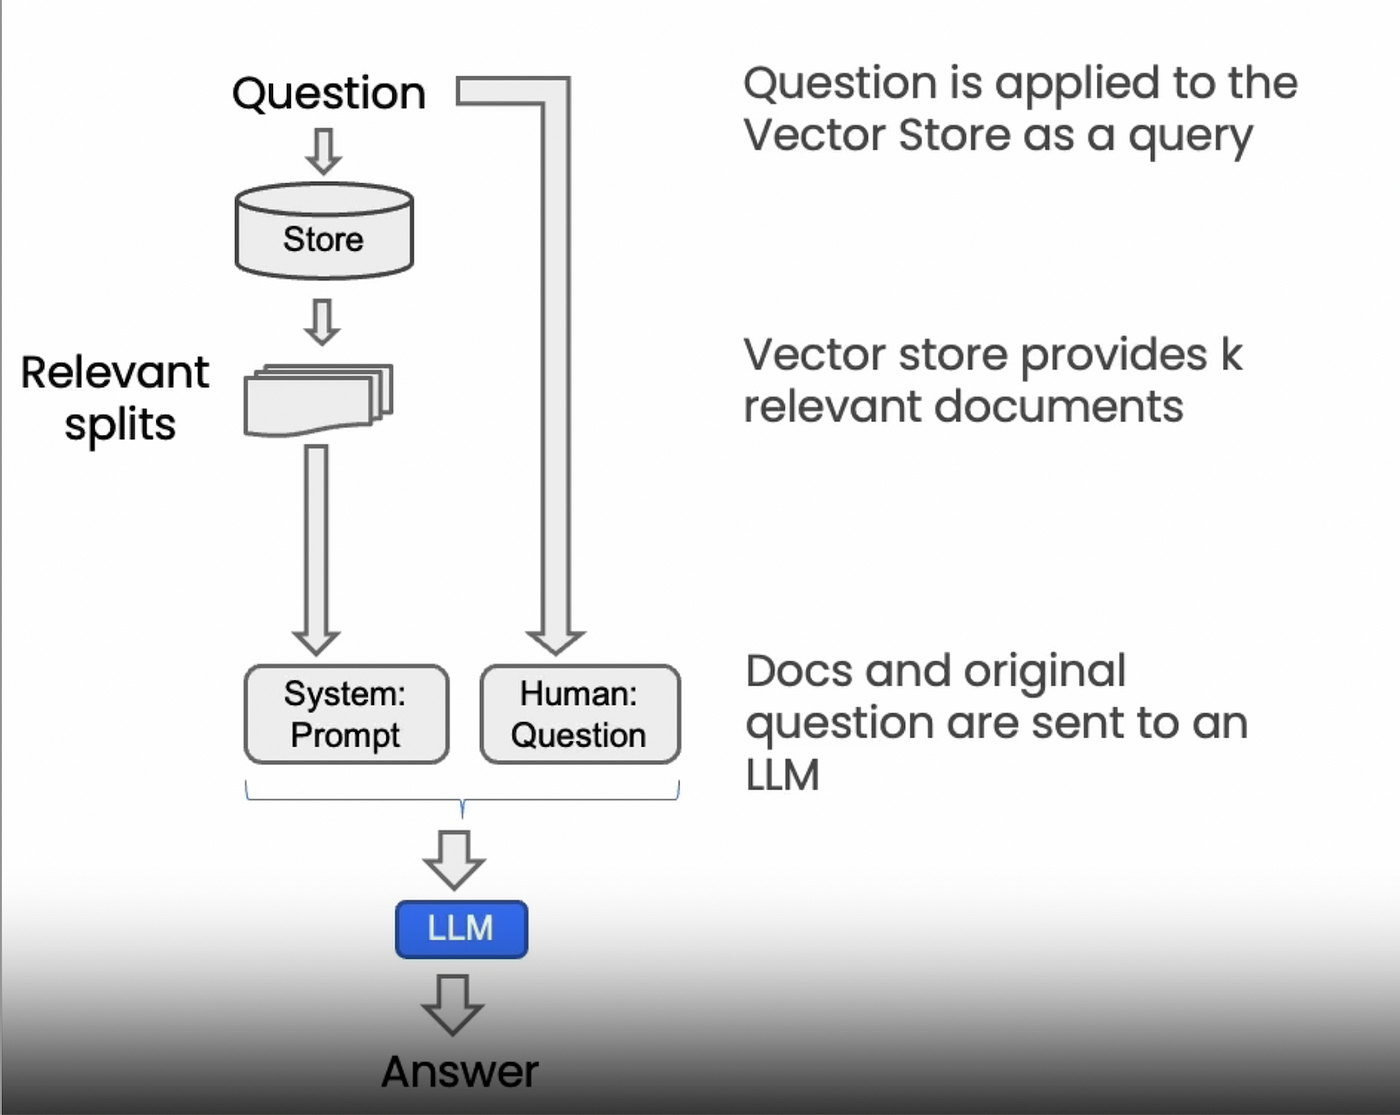

RAG exploits the strengths of Redis as a low-latency vector database for efficient retrieval operations and Google's Vertex AI to generate a coherent text response. In LLM applications, RAG enables a deeper comprehension of context, returning highly nuanced responses, even to intricate queries. This pattern enhances the interactive capability of applications, delivering more precise and informative responses, thereby significantly enriching the user experience.

In order to build a RAG pipeline for question answering, we need to use Vertex PaLM API for text generation (`text-bison@001`).

In [ ]:
# Define generation model
generation_model = TextGenerationModel.from_pretrained("text-bison@001")

response = generation_model.predict(prompt="What is a large language model?")

print("Example response:\n", response.text)

Example response:
 A large language model (LLM) is a type of artificial intelligence (AI) model that can understand and generate human language. LLMs are trained on massive datasets of text and code, and they can learn to perform a wide variety of tasks, such as translating languages, writing different kinds of creative content, and answering your questions in an informative way.

LLMs are still under development, but they have the potential to revolutionize many industries. For example, LLMs could be used to create more accurate and personalized customer service experiences, to help doctors diagnose and treat diseases, and to even write entire books and movies.




In order to be able to answer questions **while referencing domain-specific sources** (like our sample hackernews dataset), we must build a RAG pipeline:

1. First perform **Semantic Search** with the user query on the knowledge base (stored in Redis) to find relevant sources that will help the language model answer and respond intelligently.

2. The sources (called context) are "stuffed" into the prompt (input).

3. The context is retrieved and passed to the LLM application to be augmented.

4. Lastly, the full prompt is passed on to the language model for text generation.

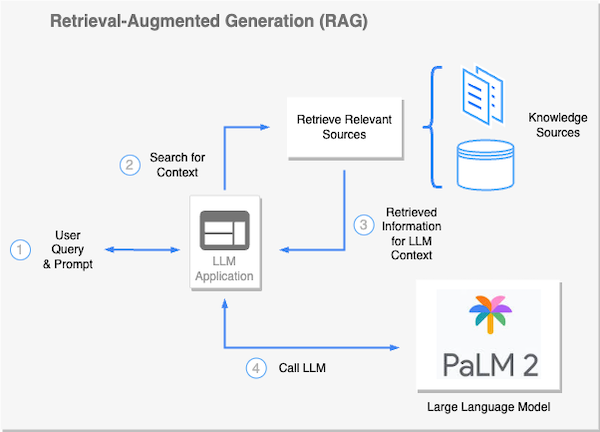

In [ ]:
def create_prompt(prompt_template: str, **kwargs) -> str:
  return prompt_template.format(**kwargs)

def rag(query: str, prompt: str, verbose: bool = True) -> str:
    """
    Simple pipeline for performing retrieval augmented generation with
    Google Vertex PaLM API and Redis Enterprise.
    """
    # Perform a vector similarity search in Redis
    if verbose:
        print("Pulling relevant data sources from Redis", flush=True)
    relevant_sources = redis_vector_db.similarity_search_with_score(query, k=3)
    df_source = pd.DataFrame([(t.__dict__, 1-s) for t, s in relevant_sources], columns =['page_content', 'score'])
    df_source['document'] = df_source['page_content'].apply(lambda x: x['metadata']).apply(lambda y: y['id'])
    df_source['page_content'] = df_source['page_content'].apply(lambda x: x['page_content'])

    if verbose:
        print("Relevant sources found!", flush=True)
    # Combine the relevant sources and inject into the prompt
    sources_text = u"\U0001F449" + " \n\U0001F449".join([source for source in df_source['page_content']])
    full_prompt = create_prompt(
        prompt_template=prompt,
        sources=sources_text,
        query=query
      )
    if verbose:
        print("\nFull prompt:\n\n", full_prompt, flush=True)
    # Perform text generation to get a response from PaLM API
    response = generation_model.predict(prompt=full_prompt)
    return response.text

Below is an example prompt template. Feel free to edit and tweak the initial sentence that sets the context for the language model to perform the action we are anticipating. The process of tuning and iterating on prompt design is widely referred to as "*prompt engineering*".

In [ ]:
PROMPT = """You are a helpful virtual technology and IT assistant. Use the sources below as relevant context to help answer the user question. Don't blindly make things up. If you don't know the answer, just say that you don't know, don't try to make up an answer. Keep the answer as concise as possible.

SOURCES:
{sources}

QUESTION:
{query}?

ANSWER:"""

In [ ]:
query = "What is RedisBloom?"
response = rag(query=query, prompt=PROMPT)
print(response)

Pulling relevant data sources from Redis
Relevant sources found!

Full prompt:

 You are a helpful virtual technology and IT assistant. Use the sources below as relevant context to help answer the user question. Don't blindly make things up. If you don't know the answer, just say that you don't know, don't try to make up an answer. Keep the answer as concise as possible.

SOURCES:
👉RedisBloom - a Redis module that extends Redis with probabilistic data structures such as Bloom and Cuckoo Filters - has been added with TopK and CountMinSketch :)<p>Feedback is welcome: https:&#x2F;&#x2F;github.com&#x2F;RedisBloom&#x2F;RedisBloom&#x2F;releases&#x2F;tag&#x2F;v1.99.0 
👉At RedisLabs, we&#x27;ve just released the first release candidate of RedisTimeSeries - a time series data structure for Redis. We would love to get your feedback!<p><a href="https:&#x2F;&#x2F;github.com&#x2F;RedisTimeSeries&#x2F;RedisTimeSeries&#x2F;releases&#x2F;tag&#x2F;v0.99.0" rel="nofollow">https:&#x2F;&#x2F;github.com&#x

### LLM Caching

**LLM Caching** is an advanced strategy used to optimize the performance of Large Language Model (LLM) applications. Utilizing the ultra-fast, in-memory data store of Redis, LLM Caching enables the storage and quick retrieval of pre-computed responses generated by Google's Vertex AI (PaLM). This means the computationally expensive process of response generation, especially for repetitive queries, is significantly reduced, resulting in faster response times and efficient resource utilization. This pairing of Google's powerful generative AI capabilities with Redis' high-performance caching system thus facilitates a more scalable and performant architecture for LLM applications, improving overall user experience and application reliability.

There are primarily two modes of caching for LLMs:
- Standard Caching
- Semantic Caching

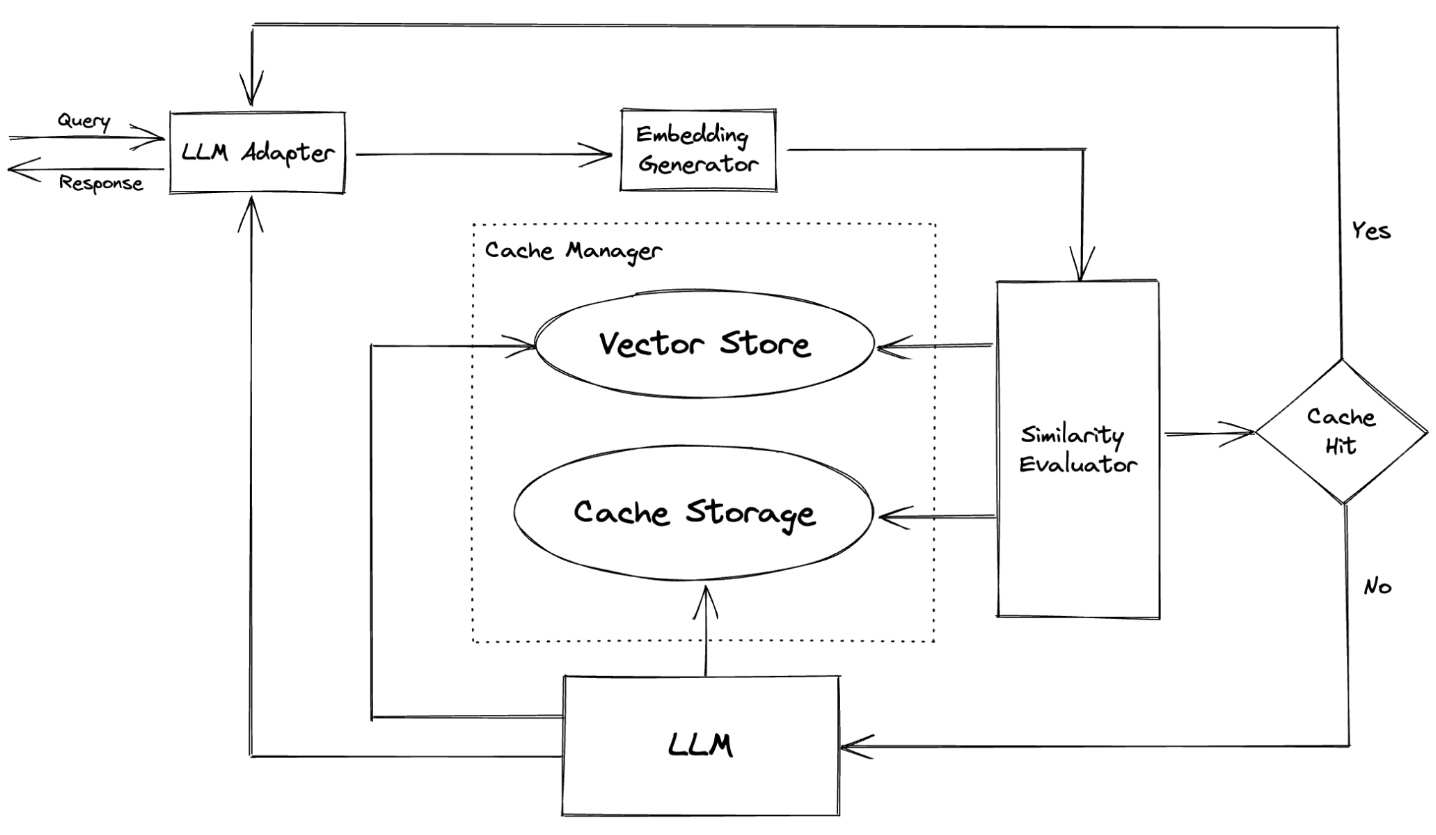

#### 1. Standard Caching

Standard caching for LLMs involves simply matching an exact phrase or prompt that has been provided before. We can return the previously used response from the LLM in order to speed up the throughput of the system overall and reduce redundant computation.

In [ ]:
# Some boiler plate helper methods

def hash_input(prefix: str, _input: str):
    return prefix + hashlib.sha256(_input.encode("utf-8")).hexdigest()

def standard_check(key: str):
  # function to perform a standard cache check
    res = redis_client.hgetall(key)
    if res:
      return res[b'response'].decode('utf-8')

def cache_response(query: str, response: str):
    key = hash_input("std:llmcache:", query)
    redis_client.hset(key, mapping={"prompt": query, "response": response})

# LLM Cache wrapper / decorator function
def standard_llmcache(llm_callable):
    def wrapper(*args, **kwargs):
        # Check LLM Cache first
        key = hash_input("std:llmcache:", *args, **kwargs)
        response = standard_check(key)
        # Check if we have a cached response we can use
        if response:
            return response
        # Otherwise execute the llm callable here
        response = llm_callable(*args, **kwargs)
        cache_response(query, response)
        return response

    return wrapper

In [ ]:
# Define a function that invokes the PaLM API wrapped with a cache check

@standard_llmcache
def ask_palm(query: str):
  response = rag(query, PROMPT, verbose=False)
  return response

Now let's Ask our application:

In [ ]:
%%time

query = "What is data mesh?"
ask_palm(query)

CPU times: user 39.9 ms, sys: 5.12 ms, total: 45 ms
Wall time: 1.84 s


'A data mesh is a framework that enables business domains to own and operate their domain-specific data without the need for a centralized intermediary. It draws from distributed computing principles, where software components are shared among multiple computers running together as a system. In this way, data ownership is spread across business domains, each of which is responsible for creating its own products. A data mesh–in theory, anyway–allows easier contextualization of the collected information to generate deeper insights while simultaneously facilitating collaboration between domain owners to create tailored solutions according to specific needs.'

Now, if we ask the same question again -- we should get the same response in near real-time.

In [ ]:
%%time

query = "What is data mesh?"
ask_palm(query)

CPU times: user 1.15 ms, sys: 0 ns, total: 1.15 ms
Wall time: 81.6 ms


'A data mesh is a framework that enables business domains to own and operate their domain-specific data without the need for a centralized intermediary. It draws from distributed computing principles, where software components are shared among multiple computers running together as a system. In this way, data ownership is spread across business domains, each of which is responsible for creating its own products. A data mesh–in theory, anyway–allows easier contextualization of the collected information to generate deeper insights while simultaneously facilitating collaboration between domain owners to create tailored solutions according to specific needs.'

#### 2. Semantic Caching
Semantic caching builds off of the same concept as above but takes advantage of Redis' vector database features to lookup smenatically similar prompts that have been applied before -- this makes it possible to cache responses of queries that are very similar in meaning, but not necessarily using the exact same words + phrases. This widens the "hit rate", making LLM caching even more effective in practice.

In [ ]:
# Some boiler plate helper methods

def semantic_check(cache: SemanticCache, query: str):
  # function to perform a semantic cache check
    cached_result = cache.check(prompt=query)
    return cached_result

def semantic_cache_response(cache: SemanticCache, query: str, response: str):
    cache.store(query, response)

# Semantic LLM Cache wrapper / decorator function
def semantic_llmcache(llm_callable):
    def wrapper(*args, **kwargs):
        cache = SemanticCache(redis_url=redis_url, threshold=0.7)
        # Check Semantic LLM Cache first
        response = semantic_check(cache, query)
        # Check if we have a cached response we can use
        if response:
            print("Retrieving cached response...\n")
            return response[0]
        # Otherwise execute the llm callable here
        response = llm_callable(*args, **kwargs)
        semantic_cache_response(cache, query, response)
        return response

    return wrapper

In [ ]:
# Define a function that invokes the PaLM API wrapped with a semantic cache check

@semantic_llmcache
def ask_palm_semantic(query: str):
  response = rag(query, PROMPT, verbose=False)
  return response

In [ ]:
%%time

ask_palm_semantic(query = "What is data mesh?")

CPU times: user 193 ms, sys: 10.8 ms, total: 204 ms
Wall time: 2.36 s


'A data mesh is a framework that enables business domains to own and operate their domain-specific data without the need for a centralized intermediary. It draws from distributed computing principles, where software components are shared among multiple computers running together as a system. In this way, data ownership is spread across business domains, each of which is responsible for creating its own products. A data mesh–in theory, anyway–allows easier contextualization of the collected information to generate deeper insights while simultaneously facilitating collaboration between domain owners to create tailored solutions according to specific needs.'

In [ ]:
%%time

ask_palm_semantic(query = "Could you explain data mesh?")

Retrieving cached response...

CPU times: user 82.8 ms, sys: 2.62 ms, total: 85.4 ms
Wall time: 595 ms


'A data mesh is a framework that enables business domains to own and operate their domain-specific data without the need for a centralized intermediary. It draws from distributed computing principles, where software components are shared among multiple computers running together as a system. In this way, data ownership is spread across business domains, each of which is responsible for creating its own products. A data mesh–in theory, anyway–allows easier contextualization of the collected information to generate deeper insights while simultaneously facilitating collaboration between domain owners to create tailored solutions according to specific needs.'

### QA History

Giving your application access to "memory" for chat history is a common technique to improve the models ability to reason through recent or past conversations, gain context from previous answers, and thus provide a more accurate and acceptable response.

Below, we setup simple helper functions to persist and load conversation history in a Redis List data structure.

In [ ]:
def add_message(prompt: str, response: str):
    msg = {
        "prompt": prompt,
        "response": response
    }
    redis_client.lpush("chat-history", json.dumps(msg))

def clear_history():
    return redis_client.delete("chat-history")

def get_messages(k: int = 5):
    return [json.loads(msg) for msg in redis_client.lrange("chat-history", 0, k)]

In [ ]:
query = "What is RedisBloom?"
response = ask_palm_semantic(query)

print(response)

add_message(query, response)

RedisBloom is a Redis module that extends Redis with probabilistic data structures such as Bloom and Cuckoo Filters.


In [ ]:
query = "What is RDI?"
response = ask_palm_semantic(query)

print(response)

add_message(query, response)

Redis Data Integration (RDI) is a tool that runs inside Redis Enterprise. It helps you synchronize data from your existing relational database into Redis in near real-time so that application read queries are completely offloaded from the relational database to Redis.


In [ ]:
query = "What's new in Redis 7.2?"
response = ask_palm_semantic(query)

print(response)

add_message(query, response)

Redis 7.2 has a lot of new features that matter to developers, including auto tiering, support for triggers and functions, expanded JavaScript and client support, and a lot of other enhancements.


In [ ]:
get_messages()

[{'prompt': "What's new in Redis 7.2?",
  'response': 'Redis 7.2 has a lot of new features that matter to developers, including auto tiering, support for triggers and functions, expanded JavaScript and client support, and a lot of other enhancements.'},
 {'prompt': 'What is RDI?',
  'response': 'Redis Data Integration (RDI) is a tool that runs inside Redis Enterprise. It helps you synchronize data from your existing relational database into Redis in near real-time so that application read queries are completely offloaded from the relational database to Redis.'},
 {'prompt': 'What is RedisBloom?',
  'response': 'RedisBloom is a Redis module that extends Redis with probabilistic data structures such as Bloom and Cuckoo Filters.'}]

# User Interface

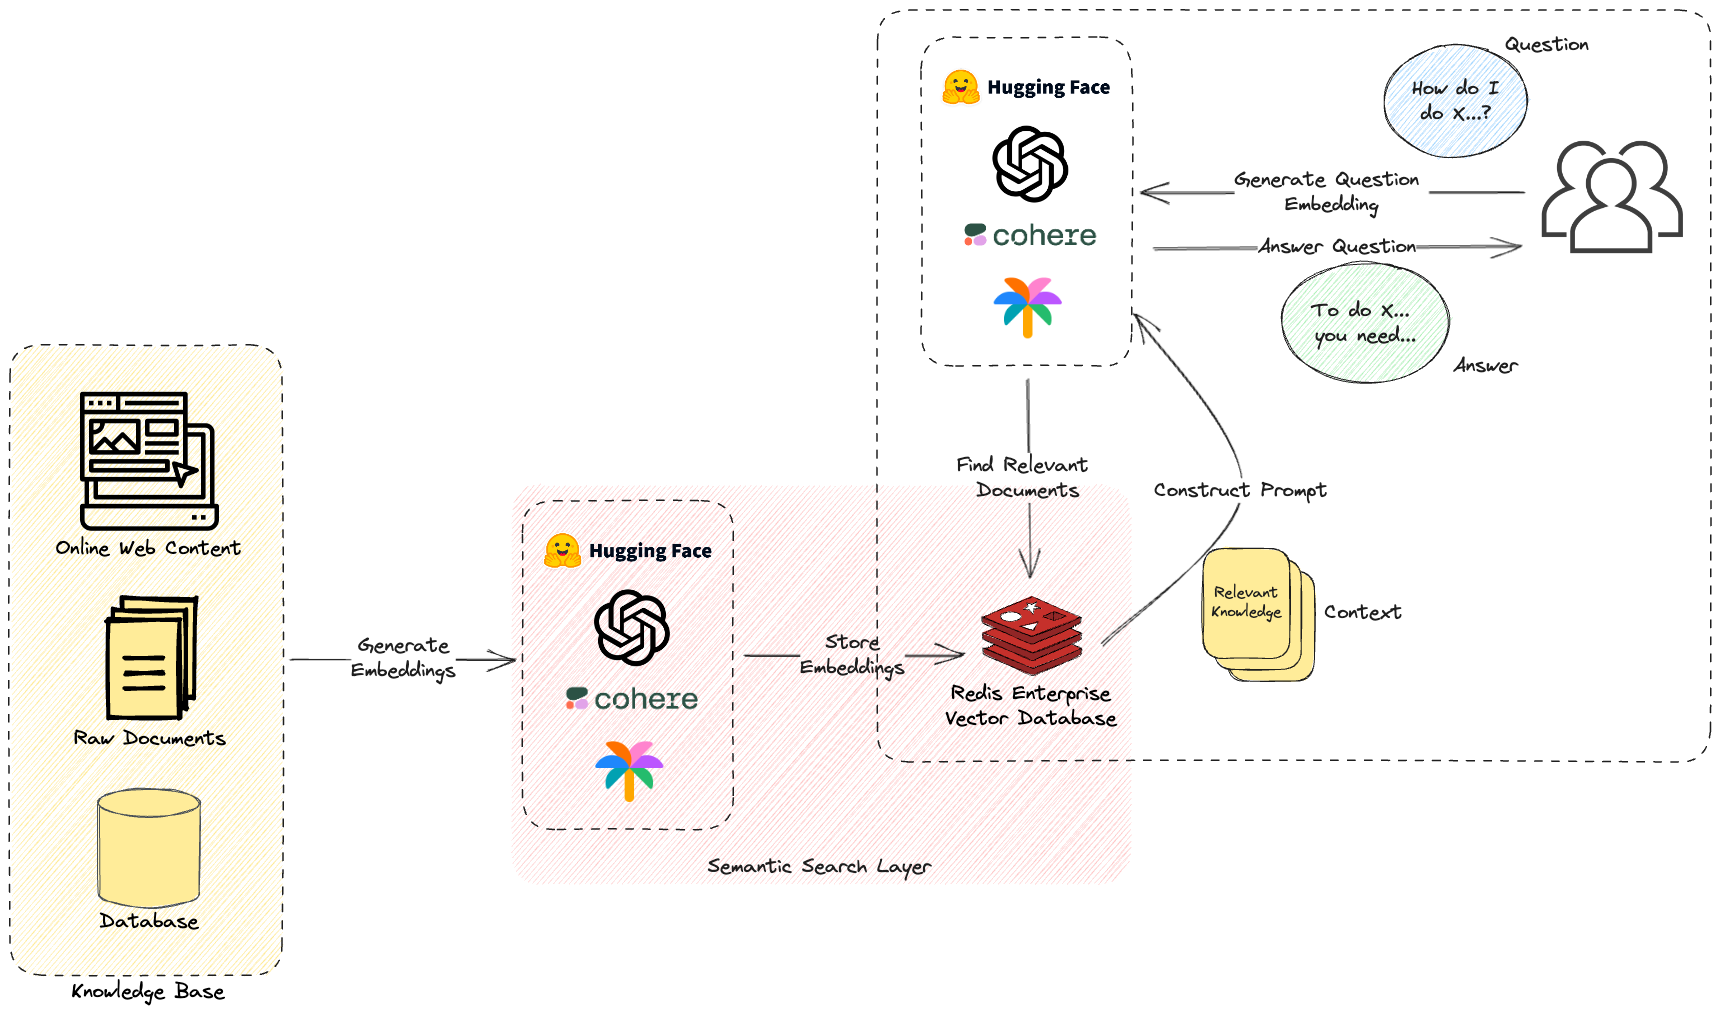

In [ ]:
def respond(request, chat_history):
    result  = ask_palm_semantic(request)
    chat_history.append((request, result))
    return "", chat_history

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=240)
    msg = gr.Textbox(label="Prompt")
    btn = gr.Button("Submit")
    clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")
    btn.click(respond, [msg, chatbot], [msg, chatbot])
    msg.submit(respond, [msg, chatbot], [msg, chatbot]) #Press enter to submit
    #hst = gr.Dataset(label='Chat History', components=[gr.Markdown()], samples=history)

gr.close_all()
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>